In [1]:
# data storage and handling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import string 

from datetime import datetime


# ignore warnings  
import warnings
warnings.filterwarnings('ignore')

In [2]:
respath = '~/Desktop/arterial_brain/results/'
date1 = datetime.today().strftime('%Y-%m-%d')
date2 = '2022-10-11'

PATH_main = respath+date1+'_Results.xlsx'
PATH_supp = respath+date1+'_SuppResults.xlsx'
PATH_desc = respath+date2+'_Descriptives.xlsx'

output_path = "/Users/Serena/Desktop/arterial_brain/results/"

In [4]:
def read_res_sheets(path, print_names = True):
    xl = pd.ExcelFile(path) # read multiple sheets
    # initiate list to store of all sheet names 
    res = list()
    # loop through the sheets and save the contents in separate dataframes
    for sheet in xl.sheet_names:
        df_name = sheet # to avoid var names problems
        res.append(df_name)
        df = xl.parse(sheet) # convert to dataframe
        if 'term' in df.columns:
            df = df.set_index('term') 
        elif 'Var' in df.columns:
            df['Var'] = df['Var'].str.strip()
            df = df.set_index('Var') 
        else:
            df = df
        
        # define outcome 
        if 'model' in df.columns:
            df['outcome'] = df['model'].str.split(" - ", expand = True)[0]
            df['outcome'] = df['outcome'].apply(lambda x : x[1:] if str(x) in ['MFA','MMD'] else x)
        
        globals()[df_name] = df
        
    if print_names: 
        print(res, '\n') # for reference 

    return([globals()[df] for df in res])

# ========================================================================================================

read_res_sheets(PATH_main);
read_res_sheets(PATH_supp);


['IMT', 'Dis', 'SBP', 'DBP', 'IMT_orig', 'Dis_orig', 'SBP_orig', 'DBP_orig', 'IMT_full', 'Dis_full', 'SBP_full', 'DBP_full'] 

['IMT_subc_vol', 'Dis_subc_vol', 'SBP_subc_vol', 'DBP_subc_vol', 'IMT_tract_FA', 'Dis_tract_FA', 'SBP_tract_FA', 'DBP_tract_FA', 'IMT_tract_MD', 'Dis_tract_MD', 'SBP_tract_MD', 'DBP_tract_MD', 'IMT_f', 'Dis_f', 'SBP_f', 'DBP_f', 'IMT_m', 'Dis_m', 'SBP_m', 'DBP_m', 'Inter', 'IMT_sexint', 'Dis_sexint', 'SBP_sexint', 'DBP_sexint', 'IMT_brain9', 'Dis_brain9', 'SBP_brain9', 'DBP_brain9', 'IMT_other', 'Dis_other', 'SBP_other', 'DBP_other'] 



# Descriptives

In [ ]:
read_res_sheets(PATH_desc);

In [ ]:
def desc(d, dec=2, s='orig'):
    
    def mean_range(var, dset, dec=dec):
        min_var  = str(round(dset.loc[0,var],dec)) if s=='imp' else str(round(float(dset['Min'].str.strip('Min. :')[var]),dec))
        max_var  = str(round(dset.loc[5,var],dec)) if s=='imp' else str(round(float(dset['Max'].str.strip('Max. :')[var]),dec))
        mean_var = str(round(dset.loc[3,var],dec)) if s=='imp' else str(round(float(dset['Mean'].str.strip('Mean. :')[var]),dec))
        sd = str(round(dset.loc[6,var],dec)) if s=='imp' else str(round(float(dset['SD'][var]),dec))
        out = mean_var+' ('+sd+') ['+min_var+'; '+max_var+']'
        return(out)
    
    if s=='imp':
        outd = pd.DataFrame(index = d.columns[~d.columns.isin(['Unnamed: 0','sex','ethnicity'])], columns=['desc'])
    else:
        outd = pd.DataFrame(index = d.index[~d.index.isin(['sex','ethnicity'])], columns=['desc'])
    
    for v in outd.index:
        outd.loc[v,'desc'] = mean_range(v, d)
    
    outd.to_csv('~/Desktop/T.csv')

# desc(s_imp_cnt_smri, s='imp') 
# desc(s_imp_cnt_dti, s='imp')
# desc(s_full.iloc[:38])
# desc(s_orig_smri)
# desc(s_orig_dti)

# ========================================================================================================

def cat_desc(d, n, s='orig'):
    t = pd.DataFrame()
    if s=='imp':
        d = d.set_index('Unnamed: 0')
        for i in d.index:
            if not i.isdigit():
                des = str(round(float(d.loc[i,'counts']),1))+' ('+str(round((float(d.loc[i,'counts'])/n)*100,1))+'%)'
                row = pd.DataFrame([[i, des]])
                t = t.append(row)
    else:
        cat = d.loc[['sex','ethnicity','m_edu_cat']].T
        for catv in ['sex','ethnicity','m_edu_cat']:
                temp = pd.DataFrame()
                temp[['A', 'B']] = cat[catv].str.split(':', 1, expand=True).dropna()
                temp['B'] = temp['B'].apply(int).apply(str)+' ('+round(temp['B'].apply(int)/n*100,1).apply(str) +'%)'
                t = t.append(temp)
                
    t.to_csv('~/Desktop/T.csv')
        
# cat_desc(s_full, n=9901)
# cat_desc(s_orig_smri, n=2054)
# cat_desc(s_orig_dti, n=2308)
# cat_desc(s_imp_cat_smri, n=2054, s='imp')
# cat_desc(s_imp_cat_dti, n=2308, s='imp')

In [22]:
d = pd.read_csv('~/Desktop/arterial_brain/DATA/Data.csv')
print(d.shape)
m = d.describe().loc['mean']+' ('
s = d.describe().loc['std']+')'

(9746, 80)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

# Main figures

In [ ]:
# general plotting parameters 
plt.rcParams["font.family"] = "sans-serif"
elw = 2.5; caps = 9; alph = 0.7; mars = 11

In [ ]:
def regr_plot(model, ax, title=None, adj='base', analysis='main', xlims=(-0.11, 0.11), fdr_pos=0.09,
              colors=['#1300FF', 'grey','crimson', '#F58713'], leg='best', bold_sign = True):
    
    title = model if title is None else title
    adjusted = 0 if adj =='base' else 1
    
    lbls = ['TBV', 'GMV', 'FA', 'MD']
    markers = ['s','s','o','o'] # circle, circle, square, square

    md = pd.DataFrame(columns=IMT.columns) # all columns are the same 
    
    if analysis =='main':
        mod = globals()[model]
    elif analysis =='fullsamp':
        mod = globals()[model+'_full']
    elif analysis=='female':
        mod = globals()[model+'_f']; colors = ['lightcoral']*len(lbls)
    elif analysis=='male':
        mod = globals()[model+'_m']; colors = ['cornflowerblue']*len(lbls)
    else:
        mod = globals()[model+'_'+analysis]
        t = ['Cingulate gyrus', 'Cortico-spinal tract', 'Uncinate fasciculus', 
             'Inferior longitudinal fasciculus', 'Superior longitudinal fasciculus', 'Major forceps', 'Minor forceps']
        if analysis == 'subc_vol':
            lbls = ['Accumbens', 'Amygdala', 'Caudate', 'Hippocampus', 'Pallidum', 'Putamen', 'Thalamus']
            markers = ['s']*len(lbls); colors = ['#1300FF']*len(lbls)
        elif analysis == 'tract_FA':
            lbls = [tract+' (FA)' for tract in t]
            markers = ['o']*len(lbls); colors = ['crimson']*len(lbls)
        elif analysis == 'tract_MD':
            lbls = [tract+' (MD)' for tract in t]
            markers = ['o']*len(lbls); colors = ['#F58713']*len(lbls) 
    
    for outc in lbls:
        df1 = mod.loc[mod['outcome']==outc].loc[model.lower()+'_9_z'].iloc[adjusted]
        md = pd.concat([md.T, df1], axis=1).T
     
    for n in range(len(md)): # md.index for y
        ax.errorbar([md['estimate'][n]], [lbls[n]], xerr = [md['std.error'][n]*1.96], color = colors[n],
                    label = '$P_{FDR}=$%0.3f'%round(md.FDR[n],2), fmt = markers[n], 
                    ms=mars, elinewidth=elw, capsize=caps, alpha=alph)
        # Add legend with FDRS
        if analysis == 'male':
            ax.errorbar(0.125, n, color = colors[n], fmt = markers[n], ms=mars, alpha=alph)
            ax.text(0.145, n+0.05, ('%.3f'%round(md.FDR[n],3))[1:], fontsize=15, va='center', ha='right')
        else:
            ax.errorbar(fdr_pos, n, color = colors[n], fmt = markers[n], ms=mars, alpha=alph)
            ax.text(fdr_pos+0.011, n+0.05, ('%.3f'%round(md.FDR[n],3))[1:], fontsize=15, va='center', ha='center')
    
    ax.text(fdr_pos+0.011, -0.8, '$P_{FDR}$', fontsize=18, ha='center')
    # Adjust axes 
    ax.set_xlim(xlims)
    ax.set_ylim(-0.5,len(md)-0.5)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=16)
    # Add x-label
    ax.set_xlabel(r'Standardized $\beta $ estimate', fontsize=18, labelpad=10)
    # add a vertical dotted line indicating beta = 0 or OR = 1.
    ax.axvline(x = 0, ymin = -1, ymax = 10, color = 'grey', ls = '--', lw = 1)
    
    if bold_sign == True:
        sign = md.reset_index().index[md['FDR']<0.05].to_list()
        for pos in sign:
            ax.get_yticklabels()[pos].set_weight("bold") 
         
    # add a title 
    ax.set_title(title, fontweight = 'bold', fontsize = 22, pad =10)

# ========================================================================================================
def make_fig(fig_size=(25, 8), hspace=0.7, wspace=0.2, lett_pos = -0.1, fdr=0.09,
             title='Base model', anal='main', adj='base', xl=(-0.11, 0.11)):
    
    f, axs = plt.subplots(2, 2, figsize=fig_size, constrained_layout = True)
    plt.rcParams["font.family"] = "sans-serif"
    
    if title[:3] == 'Sex':
        for sex in ['female','male']:
            regr_plot('IMT', axs[0,0], adj=adj, analysis=sex, xlims=xl, fdr_pos=0.1)
            regr_plot('Dis', axs[0,1], adj=adj, analysis=sex, xlims=xl, fdr_pos=0.1, title='Distensibility')
            regr_plot('SBP', axs[1,0], adj=adj, analysis=sex, xlims=xl, fdr_pos=0.1)
            regr_plot('DBP', axs[1,1], adj=adj, analysis=sex, xlims=xl, fdr_pos=0.1)
    else:
        regr_plot('IMT', axs[0,0], adj=adj, analysis=anal, xlims=xl, fdr_pos=fdr)
        regr_plot('Dis', axs[0,1], adj=adj, analysis=anal, xlims=xl, fdr_pos=fdr, title='Distensibility')
        regr_plot('SBP', axs[1,0], adj=adj, analysis=anal, xlims=xl, fdr_pos=fdr)
        regr_plot('DBP', axs[1,1], adj=adj, analysis=anal, xlims=xl, fdr_pos=fdr)
    

    f.subplots_adjust(top=0.8, hspace=hspace, wspace=wspace)
    
    for n, aa in enumerate(axs.flat):
        # n = n+from_letter
        aa.text(lett_pos, 1.1, string.ascii_uppercase[n]+'.', transform=aa.transAxes, size=22, weight='bold')

    f.suptitle(title, fontsize=30, fontweight='bold')
    
    # f.tight_layout(pad=2)
    f.savefig(output_path+'figures/'+date+'_'+title, bbox_inches="tight", dpi=400)

In [ ]:
# ========================================================================================================
make_fig()
make_fig(adj='full',title='Fully adjusted model')
# ========================================================================================================
make_fig(xl=(-0.14, 0.15), title='Sex-stratified models')
make_fig(xl=(-0.14, 0.15), adj='full', title='Sex-stratified models, fully adjusted')
# ========================================================================================================
make_fig(fig_size=(25, 12), wspace=0.3, lett_pos=-0.19, anal='subc_vol', title='Subcortical brain volumes')
make_fig(fig_size=(25, 12), wspace=0.3, lett_pos=-0.19, anal='subc_vol', adj='full', 
         title='Subcortical brain volumes, fully adjusted')
# ========================================================================================================
make_fig(fig_size=(25, 12), wspace=0.6, lett_pos=-0.55, anal='tract_FA', title='White matter tracts (FA)')
make_fig(fig_size=(25, 12), wspace=0.6, lett_pos=-0.55, anal='tract_FA', adj='full',
         title='White matter tracts (FA), fully adjusted')
# ========================================================================================================
make_fig(fig_size=(25, 12), wspace=0.6, lett_pos=-0.55, anal='tract_MD', title='White matter tracts (MD)')
make_fig(fig_size=(25, 12), wspace=0.6, lett_pos=-0.55, anal='tract_MD', adj='full',
         title='White matter tracts (MD), fully adjusted')
# ========================================================================================================
make_fig(xl=(-0.14, 0.15), title='Outcomes imputed', anal='fullsamp')
make_fig(xl=(-0.14, 0.15), adj='full', anal='fullsamp', title='Outcomes imputed, fully adjusted')


In [ ]:
def p(model, ax, title=None, xlims=(-0.13, 0.13), fdr_pos=0.09, adj=False, full=False, age=13):
    title = model if title is None else title
    md1 = md2 = pd.DataFrame(columns=IMT.columns) # all columns are the same 
    modelname = model+'_full' if full else model
    modelname = model+'_brain9' if age==9 else model
    mod = globals()[modelname]

    lbls = ['TBV', 'GMV', 'FA', 'MD']
    colors=['#1300FF', 'grey','crimson', '#F58713']
    markers = ['s','s','o','o']

    for outc in lbls:
        df1 = mod.loc[mod['outcome']==outc].loc[model.lower()+'_9_z'].iloc[0]
        df2 = mod.loc[mod['outcome']==outc].loc[model.lower()+'_9_z'].iloc[1]
        md1 = pd.concat([md1.T, df1], axis=1).T
        md2 = pd.concat([md2.T, df2], axis=1).T
    
    alph = 0.7 if adj else 1.1

    for n in range(len(md1)): # md.index for y
        ax.errorbar([md1['estimate'][n]], [lbls[n]], xerr = [md1['std.error'][n]*1.96], color = colors[n],
                    label = '$P_{FDR}=$%0.3f'%round(md1.FDR[n],2), fmt = markers[n], ms=mars, elinewidth=elw, 
                    capsize=caps, alpha=alph-0.4)
        ax.errorbar(fdr_pos, n, color = colors[n], fmt = markers[n], ms=mars, alpha=alph-0.4)
        ax.text(fdr_pos+0.01, n+0.05, ('%.3f'%round(md1.FDR[n],3))[1:], fontsize=15, va='center', ha='center')
        if adj:
            ax.errorbar([md2['estimate'][n]], [lbls[n]], xerr = [md2['std.error'][n]*1.96], color = colors[n],
                             label = '$P_{FDR}=$%0.3f'%round(md2.FDR[n],2), fmt = markers[n], 
                             ms=mars, elinewidth=elw, capsize=caps, alpha=alph)

            ax.errorbar(0.112, n, color = colors[n], fmt = markers[n], ms=mars, alpha=alph+0.1)
            ax.text(xlims[1]-0.001, n+0.05, ('%.3f'%round(md2.FDR[n],3))[1:], fontsize=15, va='center', ha='right')
    
    # Add legend with FDRS
    ax.text(fdr_pos+0.01, -0.8, '$P_{FDR}$', fontsize=18, ha='center')
    
    # Adjust axes 
    ax.set_xlim(xlims)
    ax.set_ylim(-0.5,len(md2)-0.5)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=16)
    # Add x-label
    ax.set_xlabel(r'Standardized $\beta $ estimate', fontsize=18, labelpad=10)
    # add a vertical dotted line indicating beta = 0 or OR = 1.
    ax.axvline(x = 0, ymin = -1, ymax = 10, color = 'grey', ls = '--', lw = 1)
    
    sign = md2.reset_index().index[md2['FDR']<0.05].to_list()
    for pos in sign:
        ax.get_yticklabels()[pos].set_weight("bold") 
         
    # add a title 
    ax.set_title(title, fontweight = 'bold', fontsize = 22, pad =10)

# ========================================================================================================
# f, axs = plt.subplots(2, 2, figsize=(25, 8), constrained_layout = True)

# plt.rcParams["font.family"] = "sans-serif"

# p('IMT', axs[0,0])
# p('Dis', axs[0,1], title='Distensibility')
# p('SBP', axs[1,0])
# p('DBP', axs[1,1])

# f.subplots_adjust(top=0.8, hspace=0.7, wspace=0.2)
    
# for n, aa in enumerate(axs.flat):
#     # n = n+from_letter
#     aa.text(-0.1, 1.1, string.ascii_uppercase[n]+'.', transform=aa.transAxes, size=22, weight='bold')

# tit = 'Base model' # 'Adjusted model'
# f.suptitle(tit, fontsize=30, fontweight='bold')

# f.savefig(output_path+'fig3.png', bbox_inches="tight", dpi=400)

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(25, 8), constrained_layout = True)

plt.rcParams["font.family"] = "sans-serif"

p('IMT', axs[0,0], age=9)
p('Dis', axs[0,1], age=9, title='Distensibility')
p('SBP', axs[1,0], age=9)
p('DBP', axs[1,1], age=9)

f.subplots_adjust(top=0.8, hspace=0.7, wspace=0.2)
    
for n, aa in enumerate(axs.flat):
    # n = n+from_letter
    aa.text(-0.1, 1.1, string.ascii_uppercase[n]+'.', transform=aa.transAxes, size=22, weight='bold')

tit = 'Base model' # 'Adjusted model'
f.suptitle(tit, fontsize=30, fontweight='bold')


In [ ]:
def plot_all(exp):

    def plotty(exp, outc, ax, title=None, xlims=(-1.15, 0.2), bold_sign=True):

        title = outc if title is None else title

        mod = globals()[exp]
        md = mod.loc[mod['model'].str.contains(outc+' - '+exp.upper(), na=False),]
        
        colors = ['grey' if x else 'k' for x in md['model'].str.contains('base',na=False)]

        for n in range(len(md)): # md.index for y
            ax.errorbar([md['estimate'][n]], [md.index[n]], xerr = [md['std.error'][n]*1.96], color = colors[n],
                        fmt='s', ms=mars, elinewidth=elw, capsize=caps, alpha=alph)
           
        ax.set_ylim(0.5,8.5)
        ax.set_xlim(xlims)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=18)
        effects = ['',exp,'Female sex','Age','Height','Non-european ethn.','BMI','Mat. education','Mat. age']
        ax.set_yticklabels(effects)
        ax.set_xlabel(r'Standardized $\beta $ estimate', fontsize=18, labelpad=10)
        
        # add a vertical dotted line indicating beta = 0 or OR = 1.
        ax.axvline(x = 0, ymin = -1, ymax = 10, color = 'grey', ls = '--', lw = 1)

        if bold_sign == True:
            mdf = md.loc[md['model'].str.contains('full',na=False),]
            sign = mdf.reset_index().index[mdf['FDR']<0.050].to_list()
            for pos in sign:
                ax.get_yticklabels()[pos].set_weight("bold") 

        # add a title 
        ax.set_title(title, fontweight = 'bold', fontsize = 22, pad =10)

# ========================================================================================================
    f, axs = plt.subplots(2, 2, figsize=(25, 10), constrained_layout = True)

    plt.rcParams["font.family"] = "sans-serif"

    plotty(exp,'TBV', axs[0,0])
    plotty(exp,'GMV', axs[0,1])
    plotty(exp,'FA', axs[1,0])
    plotty(exp,'MD', axs[1,1])
    
    f.subplots_adjust(hspace=0.5, wspace=0.4)

    f.suptitle(exp, fontsize=30, fontweight='bold')
    
    # f.tight_layout(pad=2)
    f.savefig(output_path+'figures/'+date+'_'+exp+'_fullmod', bbox_inches="tight", dpi=400)

plot_all('IMT')
plot_all('Dis')
plot_all('SBP')
plot_all('DBP')

In [5]:
datpath = '~/Desktop/arterial_brain/results/'
# d = pd.read_csv(datpath+'Data_imp0.csv'); 
dat = pd.read_csv(datpath+'Data_imp0.csv'); 

In [ ]:
from scipy import interpolate

# Fit the splin
def splineit(imp, exp, outc, ax):
    d = pd.read_csv(datpath+'df_by_imp/Data_imp'+str(imp)+'.csv').sort_values(by=exp.lower()+'_9_z')
    x = d[exp.lower()+'_9_z']
    y = d[outc.lower()+'_13_z']
    knot_numbers = 5
    x_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
    q_knots = np.quantile(x, x_new) 
    t,c,k = interpolate.splrep(x, y, t=q_knots, s=1)
    yfit = interpolate.BSpline(t,c,k)(x) 
    c = 'orange' if outc not in ['MFA','MMD'] else '#1300FF'
    ax.plot(x, yfit, color=c, lw=2, alpha=0.3)

def predY(exp, outc, ax):
    x = dat[exp.lower()+'_9_z']
    y = dat[outc.lower()+'_13_z']
    
    # linear regression 
    outc_name = outc if outc not in ['MFA','MMD'] else outc[1:]
    res = globals()[exp].loc[globals()[exp]['outcome']==outc_name]
    inter = res['estimate'].loc['(Intercept)'].iloc[1]
    slope = res['estimate'].loc[exp.lower()+'_9_z'].iloc[1]
    
    # scatter plot 
    c = '#82adff' if outc=='TBV' else 'grey' if outc=='GMV' else '#eb7a7a' if outc=='MFA' else '#F58713'
    
    ax.plot(x, y, 'o', color=c, alpha=0.2)
    
    # nonlinear relation 
    for imp in range(1,20):
        splineit(imp, exp=exp, outc=outc, ax=ax)
    
    # regression line
    s_err = res['std.error'].loc[exp.lower()+'_9_z'].iloc[1]
    ax.axline(xy1=(0, 0), slope=slope, ls='--',lw=2, color='k') # (0,inter)
    # confidence band
    # ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    # ax.fill_between(x2, y2 + ci, y2 - ci, alpha=1, color='r') #, color="#b9cfe7", edgecolor="")
    #ax.axline(xy1=(s_err*100, 0), slope=slope, ls='-',lw=1, color='r') # (0,inter)
    #ax.axline(xy1=(-s_err*100, 0), slope=slope, ls='-',lw=1, color='r') # (0,inter)
    
    # other settings
    ax.grid(color = 'grey', ls = '-', lw= 0.5, alpha=0.5)
    ax.set_ylim(-5.1,5.1)
    ax.set_xlim(-5.1,5.1)
    ax.tick_params(axis='both', which='major', labelsize=18)
    exp_name = exp if not exp =='Dis' else 'Distensibility'
    ax.set_xlabel(exp_name+' (z-score)', fontsize=18, labelpad=10)
    if exp == 'IMT':
        ax.set_ylabel(outc_name+' (z-score)', fontsize=18, labelpad=10, fontweight='bold')
    ax.set_title(outc_name+' ~ '+exp_name, fontsize=20, fontweight='bold')
    
    
f, axs = plt.subplots(2, 4, figsize=(30, 15), constrained_layout = True)

plt.rcParams["font.family"] = "sans-serif"

f.subplots_adjust(hspace=0.4, wspace=0.3)

predY('IMT','TBV', axs[0,0])
predY('Dis','TBV', axs[0,1])
predY('SBP','TBV', axs[0,2])
predY('DBP','TBV', axs[0,3])

predY('IMT','GMV', axs[1,0])
predY('Dis','GMV', axs[1,1])
predY('SBP','GMV', axs[1,2])
predY('DBP','GMV', axs[1,3])

f.savefig('f1.png', bbox_inches="tight", dpi=400)

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(30, 15), constrained_layout = True)

plt.rcParams["font.family"] = "sans-serif"

f.subplots_adjust(hspace=0.4, wspace=0.3)

predY('IMT','MFA', axs[0,0])
predY('Dis','MFA', axs[0,1])
predY('SBP','MFA', axs[0,2])
predY('DBP','MFA', axs[0,3])

predY('IMT','MMD', axs[1,0])
predY('Dis','MMD', axs[1,1])
predY('SBP','MMD', axs[1,2])
predY('DBP','MMD', axs[1,3])

f.savefig('f2.png', bbox_inches="tight", dpi=400)

In [9]:
dl = pd.read_csv('~/Desktop/long.csv')
for var in ['imt','dis','sbp','dbp']:
    dl[var.upper()] = pd.cut(dl[var+'_9_z'], bins=[-6,-2,2,6], labels=['Low (< -2SD)','Normal','High(> 2SD)'])


In [32]:
def plotlong(exp,outc):
    p = sns.lmplot(x='AGE', y=outc, hue=exp, data=dl, height=6, aspect=1.8, scatter=False, 
                   palette=['royalblue','mediumseagreen','crimson'])
    

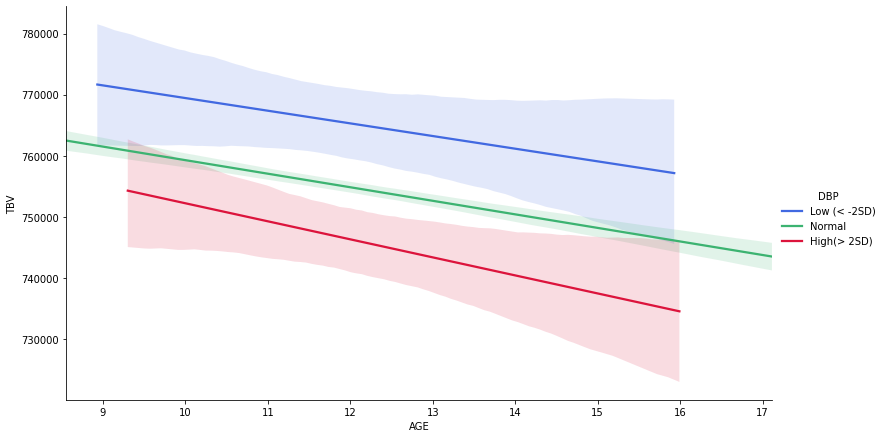

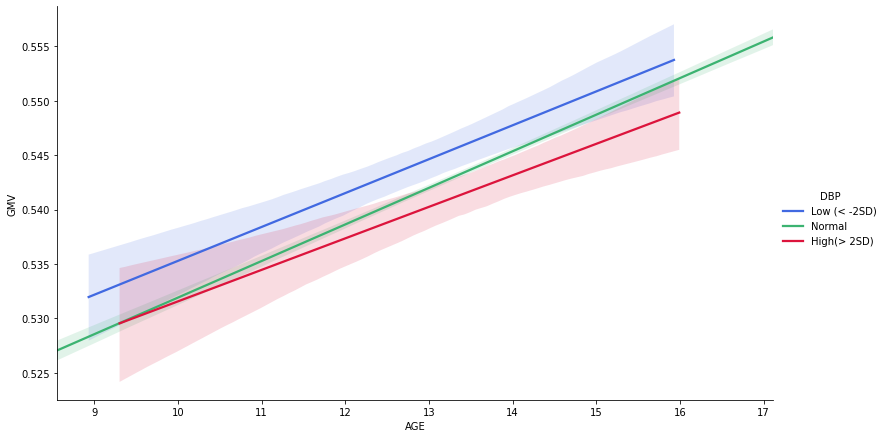

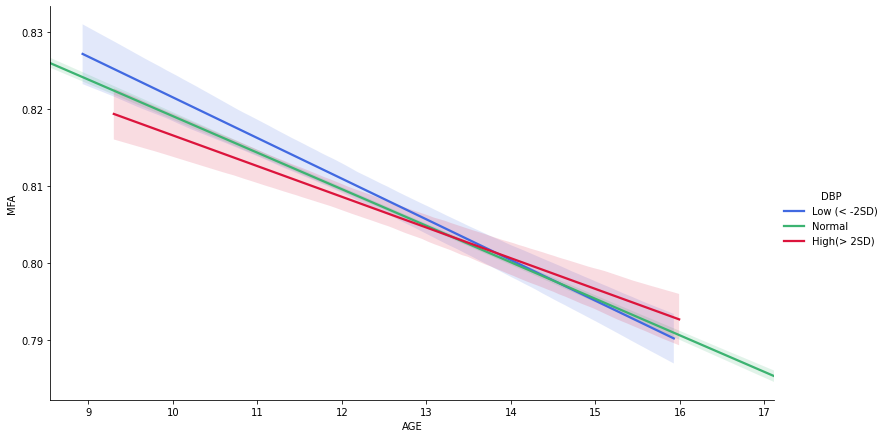

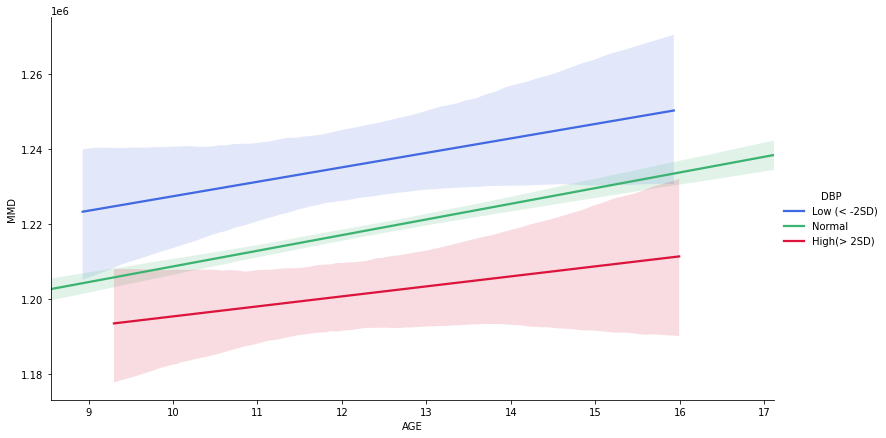

In [35]:
plotlong('DBP','TBV')
plotlong('DBP','GMV')
plotlong('DBP','MFA')
plotlong('DBP','MMD')

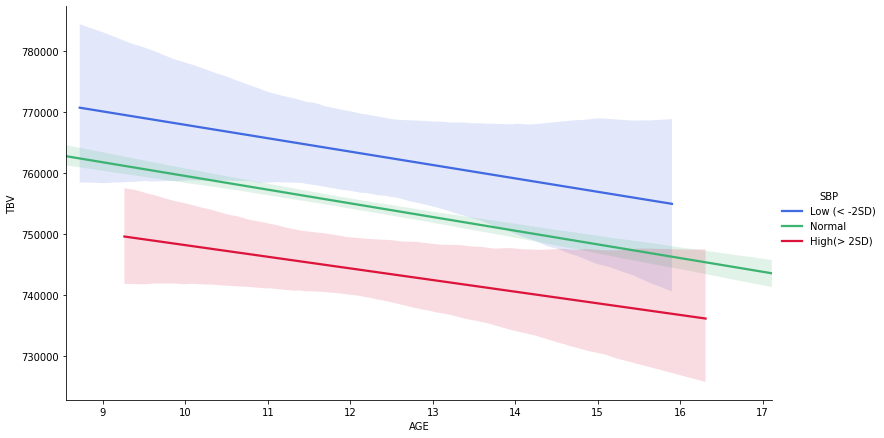

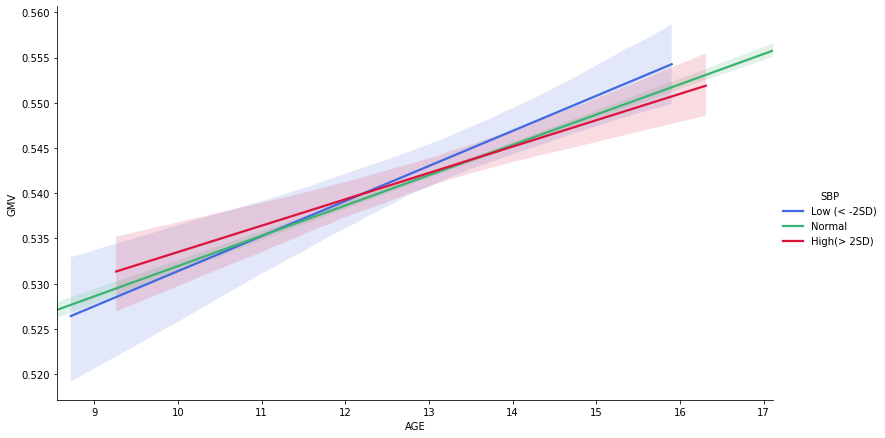

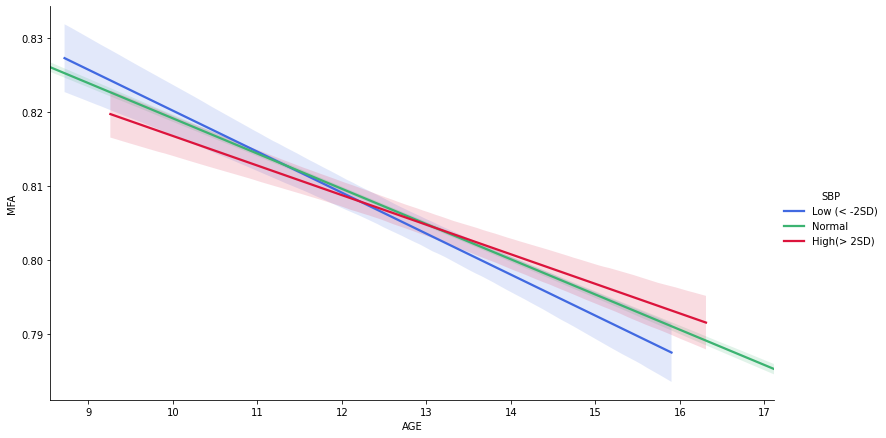

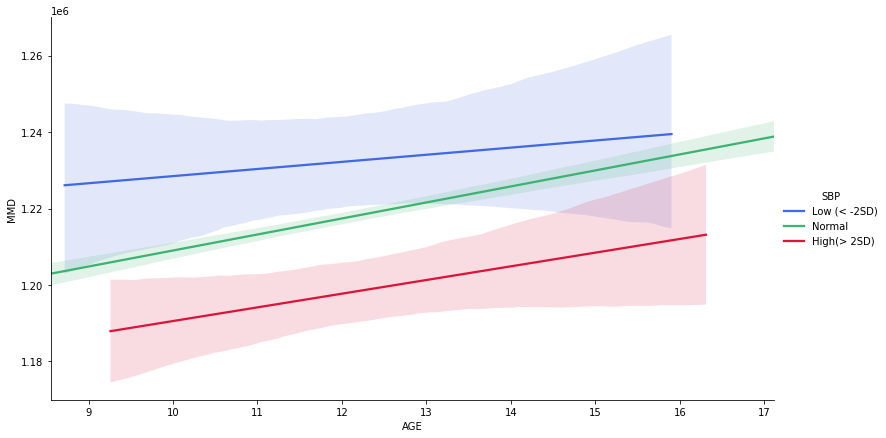

In [36]:
plotlong('SBP','TBV')
plotlong('SBP','GMV')
plotlong('SBP','MFA')
plotlong('SBP','MMD')

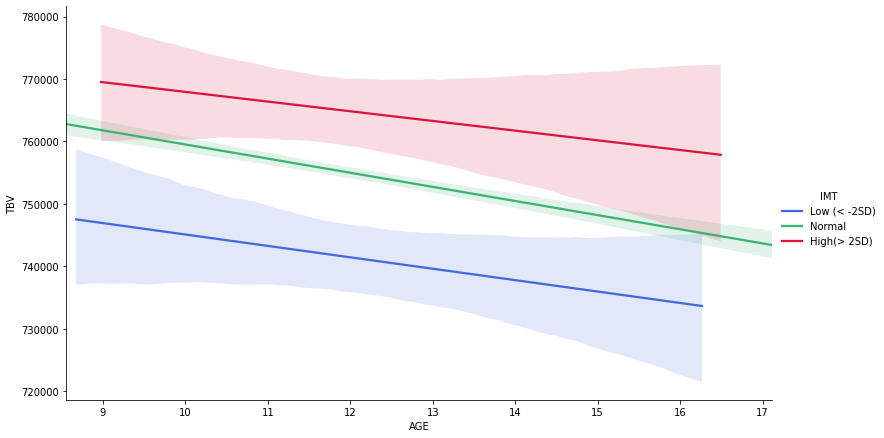

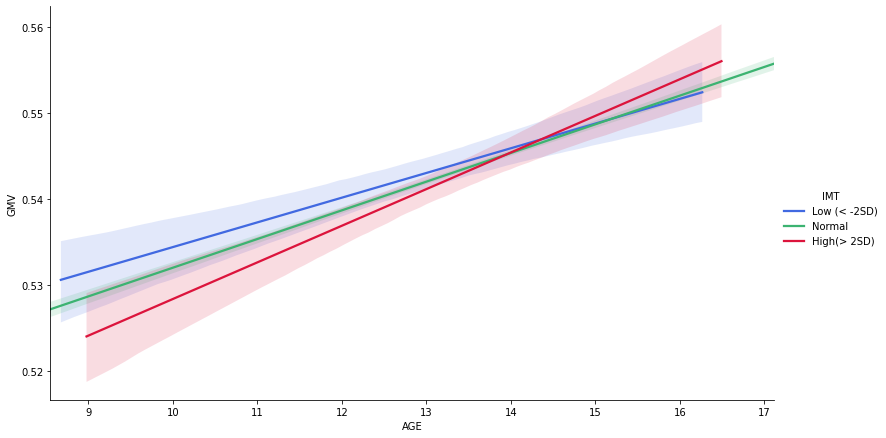

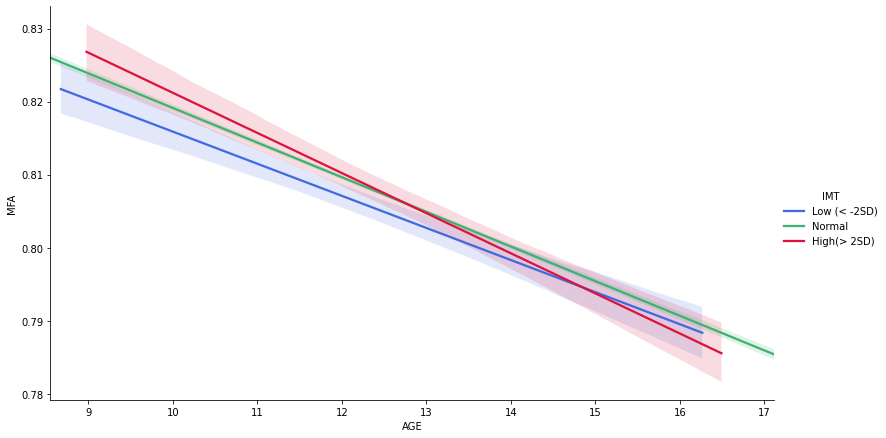

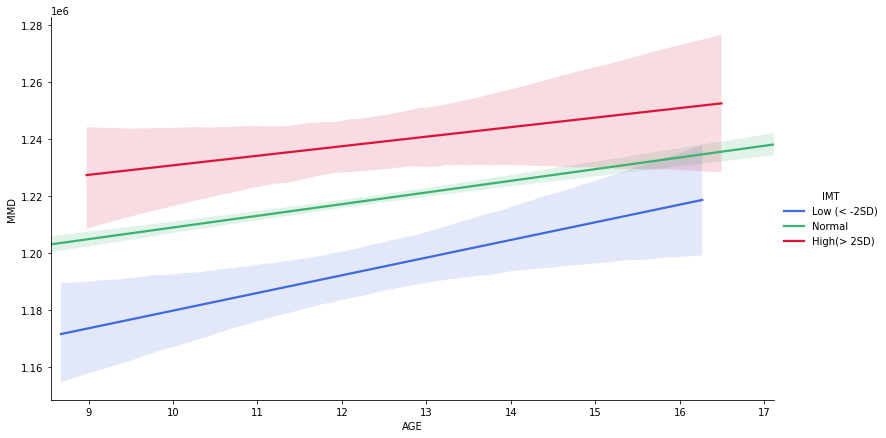

In [37]:
plotlong('IMT','TBV')
plotlong('IMT','GMV')
plotlong('IMT','MFA')
plotlong('IMT','MMD')

In [ ]:
dat['diff'] = dat['tbv_13'] - dat['tbv_9']

f, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout = True)

sns.regplot(dat['dbp_9'], dat['diff'], 'o')